程序架构：
1. 文件读取
2. 数据预处理
    - 归一化
    - 转化为监督学习(调整时间步)
    - 数据集分割(6:2:2)
3. 设计模型
4. 训练
5. x=时间步 训练

In [2]:
import requests
import csv
import os
from datetime import datetime
import time
import math
import random

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
%config InlineBackend.figure_format = 'svg'
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector

# Load Data

输出原始数据集：data_raw\<DataFrame\>


In [2]:
# 读取数据

file_path = r'C:\Users\KAI\Source\kais_lstm_load_forecasting\A_10000151_1.csv'

# 参考https://www.cnblogs.com/traditional/p/12514914.html
data_raw = pd.read_csv(file_path, header = 0)

# 调整时间戳
data_raw['ts']=data_raw['ts'].apply(lambda x:x+28800000) # 东八区
data_raw['ts'] = pd.to_datetime(data_raw['ts'], unit='ms')
data_raw.index=data_raw['ts']
del data_raw['ts']
data_raw

,value
ts,
2020-11-13 00:00:00,764.15
2020-11-13 00:01:00,766.15
2020-11-13 00:02:00,766.10
2020-11-13 00:03:00,767.35
2020-11-13 00:04:00,763.00
...,...
2020-12-12 09:28:00,790.20
2020-12-12 09:29:00,790.15
2020-12-12 09:30:00,789.45


## 按照24h划分数据：data\<[DataFrame]\>

In [3]:
# 划分为约1440一组数据（24h数据）
data=[]
split_index=[]

for index, row in data_raw.iterrows():
    if str(index)[-8:]=='00:00:00': # 开始新的一天
        split_index.append(index)
del(split_index[0])
for id in range(len(split_index)):
    if id==0:
        data.append(data_raw[:split_index[id]])
        continue
    if id == range(len(split_index)):
        data.append(data_raw[split_index[id]:])
    data.append(data_raw[split_index[id-1]:split_index[id]])

## 数据归一化: data_scaled \<[numpy.ndarray]\>

In [4]:
# normalize
scaler = scaler = MinMaxScaler(feature_range=(0, 1)) # declare scaler
data_scaled=[]
for day_data in data:
    data_scaled.append(scaler.fit_transform(day_data))

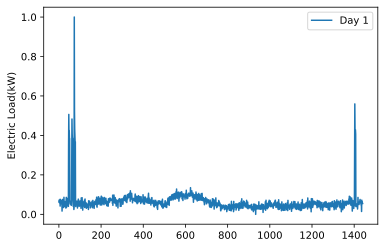

In [5]:
# 一天数据展示（day9）
day_ = 9
dt = data_scaled [day_]
plt.plot(dt,label='Day 1')
plt.legend()
plt.ylabel('Electric Load(kW)')
plt.savefig('.\原始图像.png',dpi=500,bbox_inches = 'tight')
plt.show()

In [6]:
# 三天数据
y1 = pd.Series(list(map(lambda x:x[0], data_scaled[16].tolist()))) 
y2 = pd.Series(list(map(lambda x:x[0], data_scaled[1].tolist()))) 
y3 = pd.Series(list(map(lambda x:x[0], data_scaled[20].tolist()))) 
data[20].describe()

,value
count,1345.000000
mean,800.428439
std,20.625808
min,769.900000
25%,788.850000
50%,797.750000
75%,806.650000
max,939.350000


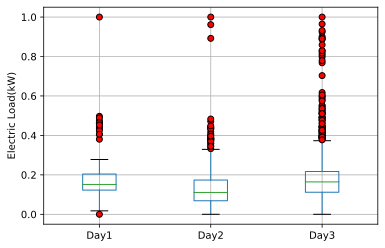

In [7]:
# 三天数据展示（箱型图）
df = pd.DataFrame({'Day1':y1,'Day2':y2,'Day3':y3})
df.boxplot(flierprops = {'marker':'o','markerfacecolor':'red','color':'black'}) # 设置异常值属性，点的形状、填充色和边框色)
plt.ylabel('Electric Load(kW)')
plt.savefig('.\原始箱型图.png',dpi=500,bbox_inches = 'tight')
plt.show()

# Prepare Data

## **离群值处理**

In [8]:
# Hampel滤波器
def hampel(X):
    length = X.shape[0] - 1
    k = 17
    nsigma = 3
    iLo = np.array([i - k for i in range(0, length + 1)])
    iHi = np.array([i + k for i in range(0, length + 1)])
    iLo[iLo < 0] = 0
    iHi[iHi > length] = length
    xmad = []
    xmedian = []
    for i in range(length + 1):
        w = X[iLo[i]:iHi[i] + 1]
        medj = np.median(w)
        mad = np.median(np.abs(w - medj))
        xmad.append(mad)
        xmedian.append(medj)
    xmad = np.array(xmad)
    xmedian = np.array(xmedian)
    scale = 1.4826  # 缩放
    xsigma = scale * xmad
    xi = ~(np.abs(X - xmedian) <= nsigma * xsigma)  # 找出离群点（即超过nsigma个标准差）
    
     # 将离群点替换为中为数值
    xf = X.copy()
    xf[xi] = xmedian[xi]
    return xf

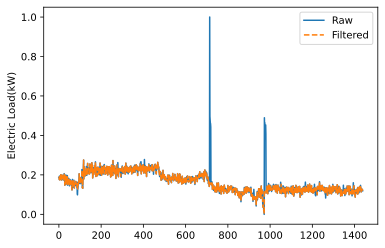

In [9]:
# 滤波器效果展示
X = data_scaled[16].reshape(data_scaled[16].shape[0],)
res = hampel(X)
plt.plot(X,label='Raw')
plt.plot(res, '--',label='Filtered')
plt.legend()
plt.ylabel('Electric Load(kW)')
plt.savefig('.\Hampel滤波器.png',dpi=500,bbox_inches = 'tight')
plt.show()

In [10]:
# 数据全部滤波处理
data_scaled_filtered = []
for day_data in data_scaled:
    tmp = hampel(day_data.reshape(day_data.shape[0],))
    tmp = tmp.reshape(tmp.shape[0],1)
    data_scaled_filtered.append(tmp)

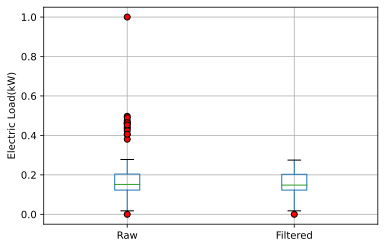

In [11]:
# 三天数据展示（箱型图）
X = data_scaled[16].reshape((data_scaled[16].shape[0],))
res = hampel(X)
y1 = pd.Series(X.tolist()) 
y2 = pd.Series(res.tolist()) 

df = pd.DataFrame({'Raw':y1,'Filtered':y2})
df.boxplot(flierprops = {'marker':'o','markerfacecolor':'red','color':'black'}) # 设置异常值属性，点的形状、填充色和边框色)
plt.ylabel('Electric Load(kW)')
plt.savefig('.\Hampel滤波器后箱型图.png',dpi=500,bbox_inches = 'tight')
plt.show()

In [12]:
# convertseries to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, drop_nan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    colums, names = [],[]
    
    # 输入序列 (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        colums.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        colums.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else: 
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(colums, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if drop_nan:
        agg.dropna(inplace=True)

    return agg

# 交叉验证分割数据集(k折交叉验证)

## 划分

all：28

k：27

总测试次数：28

In [13]:
k = 27
all_set_num = len(data_scaled_filtered)
cv_test_raw = []
cv_train_raw = []
for i in range(all_set_num):
    cv_all_raw = data_scaled_filtered.copy()
    cv_test_raw.append(cv_all_raw[i])
    del(cv_all_raw[i])
    cv_train_raw.append(cv_all_raw)

'''
    输出：
        cv_test_raw  <list> [numpy.ndarray]
        cv_train_raw <list> [[numpy.ndarray]]
'''

'\n    输出：\n        cv_test_raw  <list> [numpy.ndarray]\n        cv_train_raw <list> [[numpy.ndarray]]\n'

 **训练流程：**
- 从 cv_train 所有训练数据
- 训练数据拼接串联
- 测试、训练 数据生成 监督序列
- 训练

## 生成监督序列

In [14]:
cv_train_series = []
ts=15 # time_step
paras_dim = 1 # 用于预测的参数维度（负荷、温度、湿度...）
cv_train_spv = []
cv_test_spv = []

# 拼接串联训练数据
for dataset in cv_train_raw:
    tmp = []
    for datas in dataset:
        tmp.extend(datas)
    cv_train_series.append(tmp)
    
# 生成监督数据集
for datasets in cv_train_series:
    tmp = series_to_supervised(datasets,ts,paras_dim) 
    cv_train_spv.append(tmp)
for datasets in cv_test_raw:
    tmp = series_to_supervised(datasets,ts,paras_dim) 
    cv_test_spv.append(tmp)

In [15]:
# R2 计算公式
from keras import backend as K

# def r_square(y_true, y_pred):
#     SSR = K.mean(K.square(y_pred-K.mean(y_true)),axis=-1)
#     SST = K.mean(K.square(y_true-K.mean(y_true)),axis=-1)
#     return SSR/SST
def r_square(y_true, y_pred):
    mse = K.mean(K.square(y_pred - y_true), axis=-1)
    return 1-mse/(K.var(y_true))

# model1：FFNN

## 模型设计

In [16]:
def creat_model_1():
    model = Sequential()
    model.add(Dense(15,
                     input_shape=(15,1),
                     activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31,
                     activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1,
                     activation='sigmoid'))

    model.compile(optimizer = 'sgd',
                   loss='mse',
                   metrics=[r_square,'mse','mape'])
    return model

## 加载模型(可选)

In [17]:
# # 加载整个模型(自定义metrics需要添加参数：custom_objects={"my_loss": my_loss })
# model = load_model('my_model.h5')
# # 加载模型结构
# model = model_from_json(open('model_architecture_1.json', 'r').read())
# # 加载模型权重
# model.load_weights('weights-improvement-40-0.96208.hdf5')

## k-fold CV

### 训练模型

In [150]:
def one_fold_train(model, train, epochs_num=30, batch_size=50):
    # 划分输入输出（最后一列为输出/待预测值）
    to_train = train.values
    train_X, train_Y = to_train[:, :-1], to_train[:, -1]

    # reshape input to be 3D [samples, timesteps, dim]
    train_X = train_X.reshape((-1, train_X.shape[1], 1))

    history = model.fit(train_X, train_Y,
                      epochs = epochs_num, 
                      batch_size = batch_size)
    return history

In [19]:
def one_fold_test(model, test):
    to_test = test.values
    test_X, test_Y = to_test[:, :-1], to_test[:, -1]
    test_X = test_X.reshape((-1, test_X.shape[1], 1)) 
    scores = model.evaluate(test_X, test_Y, verbose=0)
    mse =scores[2]
    mape =scores[3]
    return {'mse':mse, 'mape':mape }

In [20]:
def one_fold_model1(train,test):
    # 创建模型1
    model = creat_model_1()
    # 训练
    hs_one = one_fold_train(model, train)
    # 评估模型
    score_one = one_fold_test(model,test)
    r2 = hs_one.history['r_square'][-1]
    mse = score_one['mse']
    mape = score_one['mape']
    return {'r2':r2, 'mse':mse, 'mape':mape }

In [281]:
cv_results_model1 = []
for i in tqdm(range(len(cv_test_spv))):
    cv_results_model1.append(one_fold_model1(cv_train_spv[i],cv_test_spv[i]))

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1/30
776/776 [==============================] - 1s 2ms/step - loss: 0.1262 - r_square: -0.0584 - mse: 0.1262 - mape: 5547994.5000
Epoch 2/30
776/776 [==============================] - 1s 2ms/step - loss: 0.1214 - r_square: -0.0190 - mse: 0.1214 - mape: 5478340.0000
Epoch 3/30
776/776 [==============================] - 2s 2ms/step - loss: 0.1161 - r_square: 0.0254 - mse: 0.1161 - mape: 5357398.5000
Epoch 4/30
776/776 [==============================] - 1s 2ms/step - loss: 0.1107 - r_square: 0.0732 - mse: 0.1107 - mape: 5194647.5000
Epoch 5/30
776/776 [==============================] - 1s 2ms/step - loss: 0.1042 - r_square: 0.1258 - mse: 0.1042 - mape: 5016050.0000
Epoch 6/30
776/776 [==============================] - 2s 2ms/step - loss: 0.0966 - r_square: 0.1896 - mse: 0.0966 - mape: 4783006.0000
Epoch 7/30
776/776 [==============================] - 2s 2ms/step - loss: 0.0878 - r_square: 0.2616 - mse: 0.0878 - mape: 4521889.0000
Epoch 8/30
776/776 [==============================] -

### 验证数据

In [314]:
def score(results):
    r2_sum = 0
    mse_sum = 0
    mape_sum = 0
    num = len(results)
    for i in results:
        r2_sum = r2_sum+i['r2'] 
        mse_sum = mse_sum+i['mse'] 
        mape_sum = mape_sum+i['mape'] 
    return {'r2':r2_sum/num, 'mse':mse_sum/num, 'mape':mape_sum/num}

In [315]:
cv_final_results_model1 = score(cv_results_model1)

In [316]:
cv_final_results_model1

{'r2': 0.829861968755722,
 'mse': 0.007314333415706642,
 'mape': 1185180.3250100953}

### 结果曲线

In [317]:
def result_curve(cv_results):
    r2s = []
    mses = []
    mapes = []
    for dic in cv_results:
        r2s.append(dic['r2'])
        mses.append(dic['mse'])
        mapes.append(dic['mape'])
    return r2s,mses,mapes

In [318]:
r2s_1,mses_1,mapes_1 = result_curve(cv_results_model1)

In [329]:
mapes_1

[79682.2734375,
 120362.59375,
 14.032049179077148,
 291342.5,
 76216.640625,
 39.50674057006836,
 586900.5,
 369994.03125,
 85070.765625,
 271.5312805175781,
 89841.6953125,
 72903.171875,
 72306.09375,
 80935.8046875,
 267.5606994628906,
 95063.03125,
 86839.671875,
 340319.4375,
 201852.78125,
 85526.609375,
 67.78201293945312,
 89169.6875,
 77253.1796875,
 79553.3203125,
 68831.875,
 106476.203125,
 29953854.0,
 74092.8203125]

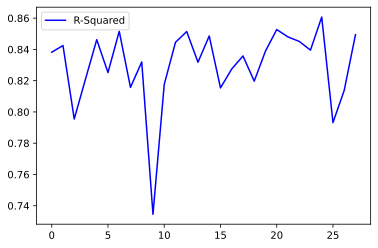

In [324]:
# R2 curve
plt.plot(r2s_1, color = 'blue' , label = 'R-Squared')
plt.legend()
plt.show()

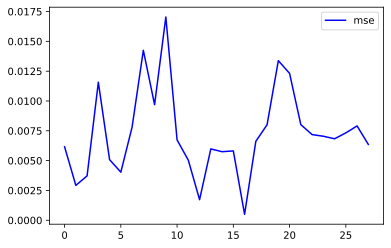

In [325]:
# mse curve
plt.plot(mses_1, color = 'blue' , label = 'mse')
plt.legend()
plt.show()

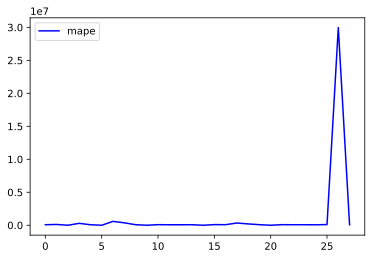

In [326]:
# mape curve
plt.plot(mapes_1, color = 'blue' , label = 'mape')
plt.legend()
plt.show()

## 数据准备

In [46]:
def prepare_data(data_raw, num_test,ts=15,paras_dim=1):
    test_model = []
    test_model_series = []
    train_model = []
    train_model_series = []
    data = data_raw.copy()
    
    # 准备test dataset series
    for idx_choose in random.sample(range(0,28),num_test):
        test_model_series.extend(data[idx_choose])
        del(data[idx_choose])
    # 准备train dataset series
    for datas in data:
        train_model_series.extend(datas)
        
    # 生成监督数据集
    train_model = series_to_supervised(train_model_series,ts,paras_dim) 
    test_model = series_to_supervised(test_model_series,ts,paras_dim)

    # 划分输入输出（最后一列为输出/待预测值）
    to_train = train_model.values
    to_test = test_model.values
    train_X, train_Y = to_train[:, :-1], to_train[:, -1]
    test_X, test_Y = to_test[:, :-1], to_test[:, -1]

    # reshape input to be 3D [samples, timesteps, dim]
    train_X = train_X.reshape((-1, train_X.shape[1], 1))
    test_X = test_X.reshape((-1, test_X.shape[1], 1))
    
    return {'train_X':train_X,'train_Y':train_Y,'test_X':test_X,'test_Y':test_Y}

In [127]:
data_dict_1 =  prepare_data(data_scaled_filtered,3)

## 训练模型

In [34]:
model1 =creat_model_1()
history = model1.fit(data_dict_1['train_X'], data_dict_1['train_Y'],
                      epochs = 50, 
                      batch_size = 50)

Epoch 1/50
719/719 [==============================] - 1s 2ms/step - loss: 0.1295 - r_square: -0.0792 - mse: 0.1295 - mape: 5860931.5000
Epoch 2/50
719/719 [==============================] - 1s 2ms/step - loss: 0.1241 - r_square: -0.0361 - mse: 0.1241 - mape: 5720760.5000
Epoch 3/50
719/719 [==============================] - 1s 2ms/step - loss: 0.1188 - r_square: 0.0058 - mse: 0.1188 - mape: 5612017.0000 : 1s - loss: 0.1218 - r_square: -0.
Epoch 4/50
719/719 [==============================] - 1s 2ms/step - loss: 0.1130 - r_square: 0.0542 - mse: 0.1130 - mape: 5440060.5000
Epoch 5/50
719/719 [==============================] - 1s 2ms/step - loss: 0.1068 - r_square: 0.1064 - mse: 0.1068 - mape: 5321395.5000
Epoch 6/50
719/719 [==============================] - 1s 2ms/step - loss: 0.0996 - r_square: 0.1683 - mse: 0.0996 - mape: 5075665.0000
Epoch 7/50
719/719 [==============================] - 1s 2ms/step - loss: 0.0916 - r_square: 0.2354 - mse: 0.0916 - mape: 4830983.0000
Epoch 8/50
719/71

## 预测

In [234]:
def predict_compared(model, test_X, test_Y,
                     low=0, high=200, bias=0, plt_target=False,
                     plt_name = 'nosense'):
    predict = model.predict(test_X)
    predict_real = scaler.inverse_transform(predict.reshape(predict.shape[0],-1))[:,0]

    true = test_X.reshape(test_X.shape[0],-1)
    true_real = (scaler.inverse_transform(true))[:,0]
    
    # calculate RMSE
    rmse = math.sqrt(mean_squared_error(true_real, predict_real))
    print('Test RMSE: %.3f' % rmse)

    if plt_target:
        # 预测表现图
        data_true=true_real[low:high]
        data_predict=predict_real[low:high] + bias
        plt.plot(list(range(len(data_predict))), data_predict, color='blue',label='predict')
        plt.plot(list(range(len(data_true))), data_true, color='black',label='real')
        plt.ylabel('Electric Load(kW)')
        plt.legend()
        file_name = '.\\predict_compared_'+ plt_name + '.png'
        plt.savefig(file_name,dpi=500,bbox_inches = 'tight')
        print('已导出至'+file_name)
        plt.show()
    return predict_real,true_real

Test RMSE: 19.589
已导出至.\predict_compared_model1.png


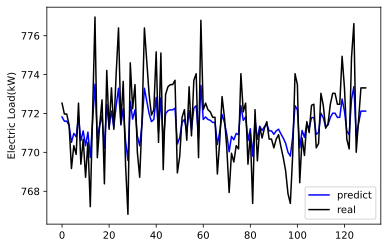

In [235]:
predict_real_1,true_real_1 = predict_compared(model1,
                                              data_dict_1['test_X'],data_dict_1['test_Y'],
                                             low=170,high=300,plt_target=True,bias=-20,
                                             plt_name='model1')

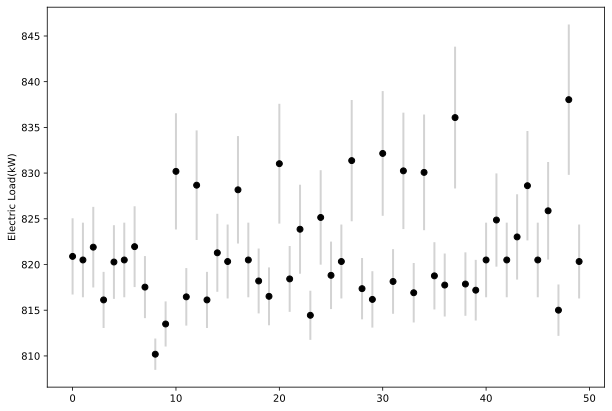

In [334]:
# 调用ax.errorbar接口，提供3个数组，x, y, yerr
# fmt控制点和线段的样式，跟ax.plot的fmt相同
# color: 控制点的颜色
# ecolor: 代表误差的线段的颜色
# elinewidth: 代表误差的线段的大小
yerr1 = []
for i in range(50):
    yerr1.append((predict_real_1[i]-true_real_1[i])/3)
fig, ax = plt.subplots(figsize=(10, 7))
plt.ylabel('Electric Load(kW)')
ax.errorbar(range(50),true_real_1[0:50], yerr=yerr1, fmt="o", color="black",
            ecolor="lightgray", elinewidth=2)
plt.savefig('.\model1_errbar.png',dpi=500,bbox_inches = 'tight')

## 导出模型

In [133]:
def save_model(model, name):
    # 保存模型整体
    model.save('model_' + name + '_overall.h5')
    print('导出模型整体成功')

    # 保存模型的结构
    yaml_string = model.to_yaml() # 方式2
    open('model_' + name + '_arthitecture.yaml', 'w').write(yaml_string)
    print('保存模型结构成功')

    # 保存模型的权重
    model.save_weights('model_' + name + '_weights.h5')
    print('保存模型权重成功')
    
    # 保存模型的基本结构图
    keras.utils.plot_model(model, 'model_' + name + '_plot.png')
    print('保存模型结构图成功')
    print('Done.')

In [134]:
save_model(model1, 'FFNN')

导出模型整体成功
保存模型结构成功
保存模型权重成功
保存模型结构图成功
Done.


#  model2: LSTM

## 模型设计

In [68]:
def creat_model_2():
    model = Sequential()
    model.add(Activation('relu'))
    model.add(LSTM(units = 128, return_sequences = True, input_shape = (ts, 1)))
    model.add(Dense(units = 1)) # 输出下一时刻的 单个值
    model.compile(optimizer = 'adam',
                   loss='mse',
                   metrics=[r_square,'mse','mape'])
    return model

## k-fold CV

In [69]:
def one_fold_model2(train,test):
    # 创建模型1
    model = creat_model_2()
    # 训练
    hs_one = one_fold_train(model, train)
    # 评估模型
    score_one = one_fold_test(model,test)
    r2 = hs_one.history['r_square'][-1]
    mse = score_one['mse']
    mape = score_one['mape']
    return {'r2':r2, 'mse':mse, 'mape':mape }

In [70]:
# 训练！！！！

cv_results_model2 = []
for i in range(len(cv_test_spv)):
    cv_results_model2.append(one_fold_model2(cv_train_spv[i],cv_test_spv[i]))

Epoch 1/50
776/776 [==============================] - 8s 10ms/step - loss: 0.0161 - r_square: 0.8628 - mse: 0.0161 - mape: 571162.9375
Epoch 2/50
776/776 [==============================] - 7s 9ms/step - loss: 0.0068 - r_square: 0.9431 - mse: 0.0068 - mape: 339901.5625
Epoch 3/50
776/776 [==============================] - 7s 10ms/step - loss: 0.0067 - r_square: 0.9437 - mse: 0.0067 - mape: 319306.7500
Epoch 4/50
776/776 [==============================] - 7s 10ms/step - loss: 0.0067 - r_square: 0.9435 - mse: 0.0067 - mape: 323537.7812
Epoch 5/50
776/776 [==============================] - 8s 10ms/step - loss: 0.0067 - r_square: 0.9439 - mse: 0.0067 - mape: 332042.3750
Epoch 6/50
776/776 [==============================] - 8s 10ms/step - loss: 0.0067 - r_square: 0.9437 - mse: 0.0067 - mape: 332488.9688
Epoch 7/50
776/776 [==============================] - 7s 9ms/step - loss: 0.0067 - r_square: 0.9437 - mse: 0.0067 - mape: 334253.4688
Epoch 8/50
776/776 [==============================] - 7s 

In [75]:
cv_final_results_model2 = score(cv_results_model2)

In [76]:
cv_final_results_model2

{'r2': 0.9463141837290355,
 'mse': 0.00538764674482601,
 'mape': 423779.4371442454}

### 结果曲线

In [273]:
r2s_2,mses_2,mapes_2 = result_curve(cv_results_model2)

In [297]:
mses_2

[0.005547878798097372,
 0.0023284158669412136,
 0.0023578889667987823,
 0.009823882952332497,
 0.0032445667311549187,
 0.002577591687440872,
 0.007273443974554539,
 0.006145530845969915,
 0.006578150205314159,
 0.0011638187570497394,
 0.006110066082328558,
 0.004503376316279173,
 0.001423192792572081,
 0.005825710482895374,
 0.004079553764313459,
 0.005804776679724455,
 0.00039779674261808395,
 0.005809328053146601,
 0.006783804390579462,
 0.01037658378481865,
 0.00924338772892952,
 0.008126706816256046,
 0.006596097256988287,
 0.004632089752703905,
 0.006502170115709305,
 0.007141038775444031,
 0.004523371811956167,
 0.0059338887222111225]

## 数据准备

In [77]:
data_dict_2 =  prepare_data(data_scaled_filtered,3)

In [78]:
len(data_dict_2['train_X'])

35958

## 训练模型

In [79]:
model2 =creat_model_2()
history_2 = model2.fit(data_dict_2['train_X'], data_dict_2['train_Y'],
                      epochs = 50, 
                      batch_size = 50)

Epoch 1/50
720/720 [==============================] - 8s 10ms/step - loss: 0.0179 - r_square: 0.8407 - mse: 0.0179 - mape: 703711.2500
Epoch 2/50
720/720 [==============================] - 8s 11ms/step - loss: 0.0071 - r_square: 0.9375 - mse: 0.0071 - mape: 417606.1875
Epoch 3/50
720/720 [==============================] - 9s 12ms/step - loss: 0.0069 - r_square: 0.9392 - mse: 0.0069 - mape: 379752.9375
Epoch 4/50
720/720 [==============================] - 9s 12ms/step - loss: 0.0069 - r_square: 0.9393 - mse: 0.0069 - mape: 374612.2812
Epoch 5/50
720/720 [==============================] - 8s 12ms/step - loss: 0.0069 - r_square: 0.9393 - mse: 0.0069 - mape: 379971.4375
Epoch 6/50
720/720 [==============================] - 9s 12ms/step - loss: 0.0069 - r_square: 0.9390 - mse: 0.0069 - mape: 392478.1562
Epoch 7/50
720/720 [==============================] - 9s 13ms/step - loss: 0.0068 - r_square: 0.9389 - mse: 0.0068 - mape: 391789.9375
Epoch 8/50
720/720 [==============================] - 9

## 预测

Test RMSE: 30.918
已导出至.\predict_compared_model2.png


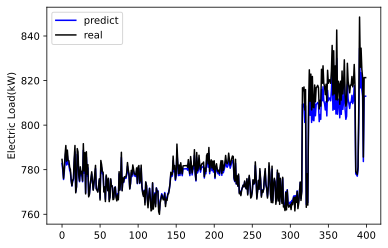

In [236]:
predict_real_2,true_real_2 = predict_compared(model2,
                                              data_dict_2['test_X'],data_dict_2['test_Y'],
                                             low=100,high=500,plt_target=True,bias=20,
                                             plt_name='model2')

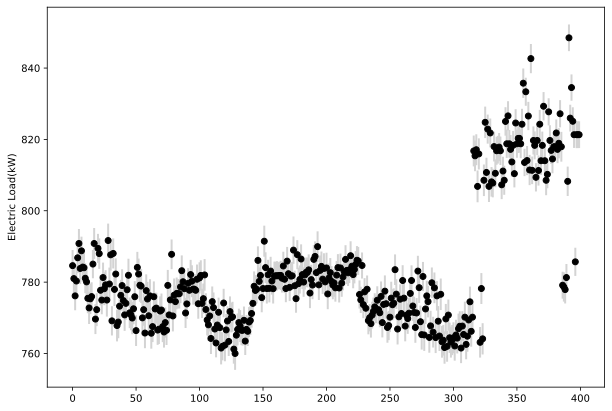

In [346]:
# 调用ax.errorbar接口，提供3个数组，x, y, yerr
# fmt控制点和线段的样式，跟ax.plot的fmt相同
# color: 控制点的颜色
# ecolor: 代表误差的线段的颜色
# elinewidth: 代表误差的线段的大小
true_real_2
predict_real_2
yerr2 = []
for i in range(400):
    yerr2.append((predict_real_2[i]-true_real_2[i])/5)
fig, ax = plt.subplots(figsize=(10, 7))
plt.ylabel('Electric Load(kW)')
ax.errorbar(range(400),true_real_2[100:500], yerr=yerr2, fmt="o", color="black",
            ecolor="lightgray", elinewidth=2)
plt.savefig('.\model2_errbar.png',dpi=500,bbox_inches = 'tight')

## 导出

In [136]:
save_model(model2, 'LSTM')

导出模型整体成功
保存模型结构成功
保存模型权重成功
保存模型结构图成功
Done.


# model3:多层LSTM

## 模型设计

In [224]:
from keras.utils.generic_utils import get_custom_objects
def custom_activation(x, beta = 1):
        return (K.sigmoid(beta * x) * x)

def creat_model_3():
    model = Sequential()

    get_custom_objects().update({'custom_activation': Activation(custom_activation)})
#     model.add(Activation(custom_activation,name = "Swish"))
    model.add(Activation('sigmoid'))#选用线性激活函数  效果较好
    model.add(LSTM(units = 128, return_sequences = True, input_shape = (ts, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 60, return_sequences = True))
    model.add(LSTM(units = 25, return_sequences = False))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) # 输出下一时刻的 单个值

#     opt = optimizers.Adam(lr=0.01)
    opt = optimizers.Adam()
    
    # 修改监控度量（默认 loss）：metrics=['mse']
    model.compile(optimizer = opt, loss = 'mse',metrics=[r_square,'mse','mape'])
    return model

## k-fold CV

In [225]:
def one_fold_model3(train,test):
    # 创建模型3
    model = creat_model_3()
    # 训练
    hs_one = one_fold_train(model, train)
    # 评估模型
    score_one = one_fold_test(model,test)
    r2 = hs_one.history['r_square'][-1]
    mse = score_one['mse']
    mape = score_one['mape']
    return {'r2':r2, 'mse':mse, 'mape':mape }

In [226]:
# 训练！！！！

cv_results_model3 = []
for i in tqdm(range(len(cv_test_spv))):
    cv_results_model3.append(one_fold_model3(cv_train_spv[i],cv_test_spv[i]))

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1/30
776/776 [==============================] - 20s 26ms/step - loss: 0.0196 - r_square: 0.8350 - mse: 0.0196 - mape: 899133.9375
Epoch 2/30
776/776 [==============================] - 20s 26ms/step - loss: 0.0083 - r_square: 0.9300 - mse: 0.0083 - mape: 306755.1250
Epoch 3/30
776/776 [==============================] - 24s 31ms/step - loss: 0.0058 - r_square: 0.9506 - mse: 0.0058 - mape: 286684.0625
Epoch 4/30
776/776 [==============================] - 25s 32ms/step - loss: 0.0047 - r_square: 0.9601 - mse: 0.0047 - mape: 323304.43750s - loss: 0.0047 - r_square: 0.9599 - mse: 0.
Epoch 5/30
776/776 [==============================] - 23s 30ms/step - loss: 0.0038 - r_square: 0.9676 - mse: 0.0038 - mape: 377745.8438
Epoch 6/30
776/776 [==============================] - 25s 33ms/step - loss: 0.0034 - r_square: 0.9713 - mse: 0.0034 - mape: 429348.5938
Epoch 7/30
776/776 [==============================] - 23s 30ms/step - loss: 0.0032 - r_square: 0.9727 - mse: 0.0032 - mape: 444251.0625
Ep

In [153]:
cv_final_results_model3 = score(cv_results_model3)

In [154]:
cv_final_results_model3

{'r2': 0.9784766563347408,
 'mse': 0.0011528074766309665,
 'mape': 261397.13538280554}

### 结果曲线

In [271]:
r2s_3,mses_3,mapes_3 = result_curve(cv_results_model3)

In [279]:
mapes_3

[413.0771789550781,
 64339.27734375,
 4.7233567237854,
 11639.228515625,
 20086.603515625,
 11.075230598449707,
 567169.3125,
 12124.955078125,
 12472.345703125,
 25.10300636291504,
 27755.548828125,
 453.1616516113281,
 43316.25390625,
 15478.84765625,
 65.70002746582031,
 13824.5009765625,
 16083.4423828125,
 13906.076171875,
 6306.669921875,
 49022.26171875,
 53.215084075927734,
 7600.08447265625,
 3130.5927734375,
 26243.298828125,
 20292.5859375,
 3288.324462890625,
 4516642.5,
 2347.2548828125]

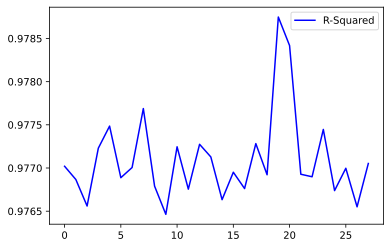

In [252]:
# R2 curve
plt.plot(r2s_3, color = 'blue' , label = 'R-Squared')
plt.legend()
plt.show()

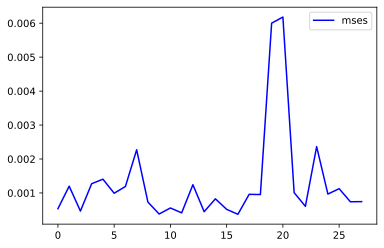

In [253]:
# mses curve
plt.plot(mses_3, color = 'blue' , label = 'mses')
plt.legend()
plt.show()

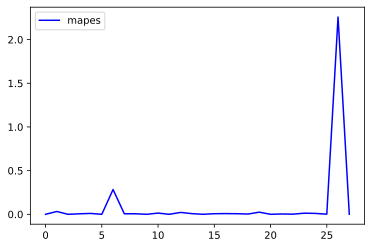

In [269]:
# mapes curve
plt.plot(mapes_3, color = 'blue' , label = 'mapes')
plt.legend()
plt.show()

## 数据准备

In [208]:
data_dict_3 =  prepare_data(data_scaled_filtered,3)

In [211]:
len(data_dict_3['train_X'])

35939

## 训练模型

In [157]:
model3 =creat_model_3()
history_3 = model3.fit(data_dict_3['train_X'], data_dict_3['train_Y'],
                      epochs = 50, 
                      batch_size = 50)

Epoch 1/50
713/713 [==============================] - 21s 30ms/step - loss: 0.0134 - r_square: 0.8843 - mse: 0.0134 - mape: 107829.3984
Epoch 2/50
713/713 [==============================] - 21s 30ms/step - loss: 0.0066 - r_square: 0.9427 - mse: 0.0066 - mape: 60040.8047
Epoch 3/50
713/713 [==============================] - 22s 31ms/step - loss: 0.0049 - r_square: 0.9578 - mse: 0.0049 - mape: 53945.2266
Epoch 4/50
713/713 [==============================] - 22s 31ms/step - loss: 0.0039 - r_square: 0.9660 - mse: 0.0039 - mape: 47960.6562
Epoch 5/50
713/713 [==============================] - 22s 31ms/step - loss: 0.0034 - r_square: 0.9707 - mse: 0.0034 - mape: 43977.1914
Epoch 6/50
713/713 [==============================] - 23s 32ms/step - loss: 0.0032 - r_square: 0.9727 - mse: 0.0032 - mape: 51154.7148
Epoch 7/50
713/713 [==============================] - 22s 31ms/step - loss: 0.0030 - r_square: 0.9740 - mse: 0.0030 - mape: 51733.6914
Epoch 8/50
713/713 [==============================] - 

## 预测

Test RMSE: 79.664
已导出至.\predict_compared_model3.png


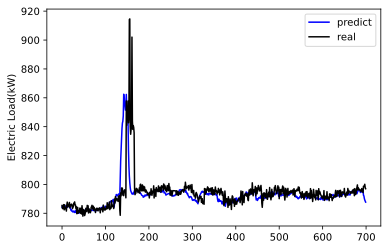

In [337]:
predict_real_3,true_real_3 = predict_compared(model3,
                                              data_dict_3['test_X'],data_dict_3['test_Y'],
                                             low=100,high=800,plt_target=True,bias=5,
                                             plt_name='model3')

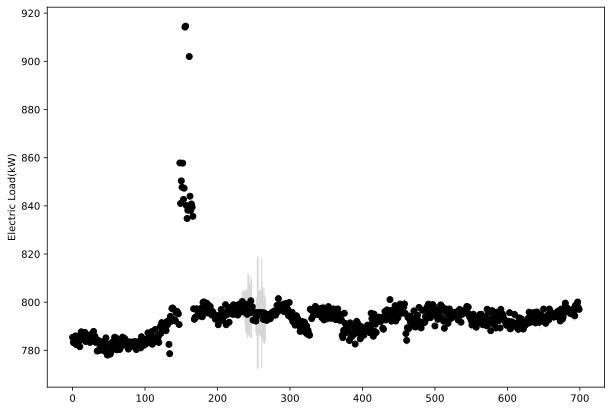

In [348]:
# 调用ax.errorbar接口，提供3个数组，x, y, yerr
# fmt控制点和线段的样式，跟ax.plot的fmt相同
# color: 控制点的颜色
# ecolor: 代表误差的线段的颜色
# elinewidth: 代表误差的线段的大小
true_real_3
predict_real_3
yerr3 = []
for i in range(700):
    yerr3.append((predict_real_3[i]-true_real_3[i])/5)
fig, ax = plt.subplots(figsize=(10, 7))
plt.ylabel('Electric Load(kW)')
ax.errorbar(range(700),true_real_3[100:800], yerr=yerr3, fmt="o", color="black",
            ecolor="lightgray", elinewidth=1)
plt.savefig('.\model3_errbar.png',dpi=500,bbox_inches = 'tight')

## 导出模型

In [ ]:
save_model(model3, 'LSTMs')

---

In [63]:
# 生成训练数据集
ts=15 # time_step
df_dt_reframed = series_to_supervised(data_scaled_filtered[2],ts,1) 
df_dt_reframed

,var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
15,0.430295,0.432863,0.431065,0.426187,0.427214,0.423107,0.426444,0.412067,0.439538,0.440822,0.429140,0.431065,0.434660,0.436970,0.401027,0.444673
16,0.432863,0.431065,0.426187,0.427214,0.423107,0.426444,0.412067,0.439538,0.440822,0.429140,0.431065,0.434660,0.436970,0.401027,0.444673,0.424134
17,0.431065,0.426187,0.427214,0.423107,0.426444,0.412067,0.439538,0.440822,0.429140,0.431065,0.434660,0.436970,0.401027,0.444673,0.424134,0.403594
18,0.426187,0.427214,0.423107,0.426444,0.412067,0.439538,0.440822,0.429140,0.431065,0.434660,0.436970,0.401027,0.444673,0.424134,0.403594,0.422080
19,0.427214,0.423107,0.426444,0.412067,0.439538,0.440822,0.429140,0.431065,0.434660,0.436970,0.401027,0.444673,0.424134,0.403594,0.422080,0.442105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,0.348139,0.343517,0.342747,0.352760,0.346598,0.341977,0.357125,0.344801,0.346341,0.354300,0.351476,0.364827,0.359435,0.359949,0.357381,0.362003
1435,0.343517,0.342747,0.352760,0.346598,0.341977,0.357125,0.344801,0.346341,0.354300,0.351476,0.364827,0.359435,0.359949,0.357381,0.362003,0.343517
1436,0.342747,0.352760,0.346598,0.341977,0.357125,0.344801,0.346341,0.354300,0.351476,0.364827,0.359435,0.359949,0.357381,0.362003,0.343517,0.377150
1437,0.352760,0.346598,0.341977,0.357125,0.344801,0.346341,0.354300,0.351476,0.364827,0.359435,0.359949,0.357381,0.362003,0.343517,0.377150,0.365083


In [67]:
# 划分数据集
split_idx_1 = int(df_dt_reframed.values.shape[0] * 0.6)
split_idx_2 = int(df_dt_reframed.values.shape[0] * 0.8)
train_set, valid_set, test_set = df_dt_reframed.values[:split_idx_1, :], df_dt_reframed.values[split_idx_1:split_idx_2, :], df_dt_reframed.values[split_idx_2:, :]
'''训练集：train_set | 验证集：valid_set | 测试集：test_set'''

'训练集：train_set | 验证集：valid_set | 测试集：test_set'

In [68]:
# 划分输入输出（最后一列为输出/待预测值）
train_X, train_Y = train_set[:, :-1], train_set[:, -1]
valid_X, valid_Y = valid_set[:, :-1], valid_set[:, -1]
test_X, test_Y = test_set[:, :-1], test_set[:, -1]
train_X.shape

(854, 15)

In [69]:
# reshape input to be 3D [samples, timesteps, dim]
train_X = train_X.reshape((-1, train_X.shape[1], 1))
valid_X = valid_X.reshape((-1, valid_X.shape[1], 1))
test_X = test_X.reshape((-1, test_X.shape[1], 1))
test_X.shape

(285, 15, 1)

# design network

In [163]:

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
def custom_activation(x, beta = 1):
        return (K.sigmoid(beta * x) * x)

def creat_model_0():
    model = Sequential()

    get_custom_objects().update({'custom_activation': Activation(custom_activation)})
    model.add(Activation(custom_activation,name = "Swish"))
#     model.add(Activation('sigmoid'))#选用线性激活函数  效果较好
    model.add(LSTM(units = 128, return_sequences = True, input_shape = (train_X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 60, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 25))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) # 输出下一时刻的 单个值

    15
#     opt = optimizers.Adam(lr=0.01)
    opt = optimizers.Adam()
    
    # 修改监控度量（默认 loss）：metrics=['mse']
    model.compile(optimizer = opt, loss = 'mse',metrics=['mae'])
    return model

-----------

# train

In [71]:
''' 训练  '''

model=creat_model_0()
history = model.fit(train_X, train_Y, epochs = 50, batch_size = 50,validation_data=(test_X,test_Y))

Epoch 1/50
18/18 [==============================] - 3s 144ms/step - loss: 0.0318 - mae: 0.1395 - val_loss: 0.0023 - val_mae: 0.0430
Epoch 2/50
18/18 [==============================] - 1s 30ms/step - loss: 0.0046 - mae: 0.0538 - val_loss: 9.8968e-04 - val_mae: 0.0258
Epoch 3/50
18/18 [==============================] - 1s 30ms/step - loss: 0.0041 - mae: 0.0511 - val_loss: 7.8684e-04 - val_mae: 0.0225
Epoch 4/50
18/18 [==============================] - 1s 29ms/step - loss: 0.0035 - mae: 0.0473 - val_loss: 4.3138e-04 - val_mae: 0.0166
Epoch 5/50
18/18 [==============================] - 1s 30ms/step - loss: 0.0030 - mae: 0.0437 - val_loss: 4.3880e-04 - val_mae: 0.0166
Epoch 6/50
18/18 [==============================] - 1s 32ms/step - loss: 0.0030 - mae: 0.0435 - val_loss: 8.9968e-04 - val_mae: 0.0248
Epoch 7/50
18/18 [==============================] - 1s 31ms/step - loss: 0.0028 - mae: 0.0421 - val_loss: 4.5825e-04 - val_mae: 0.0165
Epoch 8/50
18/18 [==============================] - 1s 33m

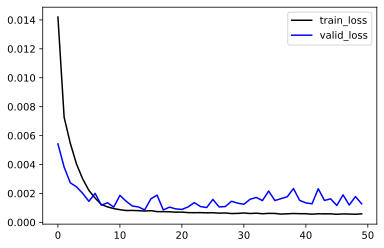

In [92]:
# loss curve
plt.plot(history.history['loss'], color = 'black' , label = 'train_loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'valid_loss')
plt.legend()
plt.show()

# 预测

In [251]:
result_predict = model.predict(test_X)
result_predict_true = scaler.inverse_transform(result_predict.reshape(result_predict.shape[0],-1))[:,0]
# result_predict_true=result_predict_true+10 ####魔法

In [252]:
test_X_raw = test_X.reshape(test_X.shape[0],-1)
test_raw_true = (scaler.inverse_transform(test_X_raw))[:,0]
test_raw_true

array([786.2878524 , 788.3420685 , 788.2907131 , ..., 785.87700918,
       786.08243079, 788.80426713])

In [253]:
# calculate RMSE
# sklearn.metrics.mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(test_raw_true, result_predict_true))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 56.338


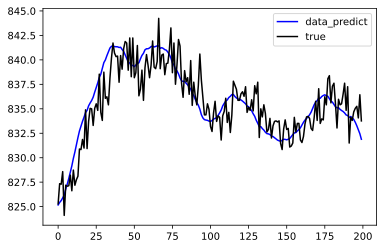

In [268]:
# 预测表现
data_true=test_raw_true[:200]

data_predict=result_predict_true[:200]

data_true=data_true+39 ####魔法

# plt.figure(figsize=(24,8))
plt.plot(list(range(len(data_predict))), data_predict, color='blue',label='data_predict')
plt.plot(list(range(len(data_true))), data_true, color='black',label='true')
plt.legend()
plt.show()

### time_step  explore 

In [ ]:
# # learning_rate 取值探究
# rand_batch = np.random.randint(train_num // batch_size)
# grad_lr = train_batch(rand_batch, batch_size, parameters)
# lr_list = []
# lower = 0.5  # 10^n pow
# upper = 1  # 10^n pow
# step = 0.05
# for lr_pow in tqdm(np.linspace(lower, upper, num=int((upper - lower) // step + 1))):
#     learn_rate = 10 ** lr_pow
#     parameters_tmp = modify_parameters(parameters, grad_lr, learn_rate)
#     train_loss_tmp = train_loss(parameters_tmp)
#     lr_list.append([lr_pow, train_loss_tmp])
# print(lr_list)
# plt.plot(np.array(lr_list)[:, 0], np.array(lr_list)[:, 1], color='black')
# plt.show()

In [ ]:
# # model.summary()
# history.history

In [ ]:
# #预测
# predicted = model.predict(test_X)
# #对预测数据还原。
# predicted = scaler.inverse_transform(predicted)

# real_value = scaler.inverse_transform(test_Y)

In [ ]:
# plt.plot(real_value, color = 'red' , label = 'real_value')
# plt.plot(predicted, color = 'blue', label = 'predicted')
# plt.title('load predict')
# plt.xlabel('Time')
# plt.ylabel('Load Value')
# plt.legend()
# plt.show()

# 函数图像

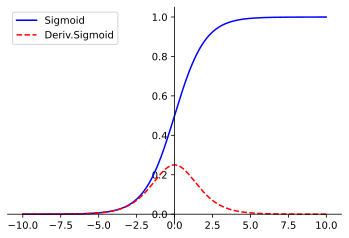

In [14]:
import math
x = np.arange(-10,10,0.01)
a=np.array(x)
y1= 1/(1+math.e**(-x))
y2= math.e**(-x)/((1+math.e**(-x))**2)
plt.xlim(-11,11)
ax = plt.gca() # get current axis 获得坐标轴对象
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')# 将右边 上边的两条边颜色设置为空 其实就相当于抹掉这两条边
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')# 指定下边的边作为 x 轴   指定左边的边为 y 轴
ax.spines['bottom'].set_position(('data', 0))#指定 data  设置的bottom(也就是指定的x轴)绑定到y轴的0这个点上
ax.spines['left'].set_position(('data', 0))
plt.plot(x,y1,label='Sigmoid',linestyle="-", color="blue")#label为标签
plt.plot(x,y2,label='Deriv.Sigmoid',linestyle="--", color="red")#l
#plt.legend(loc=0,ncol=2)
plt.legend(['Sigmoid','Deriv.Sigmoid'])

plt.savefig('Sigmoid.png', dpi=500)#指定分辨率

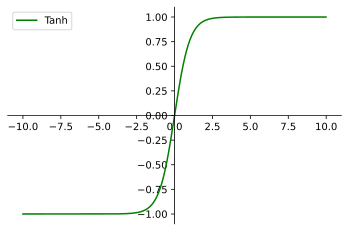

In [12]:
x = np.arange(-10,10,0.01)
a=np.array(x)
y1=(math.e**(x)-math.e**(-x))/(math.e**(x)+math.e**(-x))
plt.xlim(-11,11)
ax = plt.gca()# get current axis 获得坐标轴对象
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')# 将右边 上边的两条边颜色设置为空 其实就相当于抹掉这两条边
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')# 指定下边的边作为 x 轴   指定左边的边为 y 轴
ax.spines['bottom'].set_position(('data', 0))#指定 data  设置的bottom(也就是指定的x轴)绑定到y轴的0这个点上
ax.spines['left'].set_position(('data', 0))
plt.plot(x,y1,label='Tanh',linestyle="-", color="green")#label为标签
plt.legend(['Tanh'])
plt.savefig('Tanh.png', dpi=500) #指定分辨

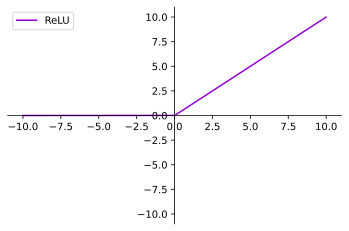

In [13]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
x = np.arange(-10, 10,0.01)
y = np.where(x<0,0,x)#满足条件(condition)，输出x，不满足输出y
plt.xlim(-11,11)
plt.ylim(-11,11)
ax = plt.gca()# get current axis 获得坐标轴对象
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')# 将右边 上边的两条边颜色设置为空 其实就相当于抹掉这两条边
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')# 指定下边的边作为 x 轴   指定左边的边为 y 轴
ax.spines['bottom'].set_position(('data', 0))#指定 data  设置的bottom(也就是指定的x轴)绑定到y轴的0这个点上
ax.spines['left'].set_position(('data', 0))
plt.plot(x,y,label='ReLU',linestyle="-", color="darkviolet")#label为标签
plt.legend(['ReLU'])
plt.savefig('ReLU.png', dpi=500) #指定分辨